In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import os
import sys

PROJECT_PATH = os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(PROJECT_PATH)


from modules.data_loaders.base_line_loaders import load_cifar10, load_hits
from transformations import Transformer
from models.encoders_decoders import conv_encoder, conv_decoder
from utils import save_roc_pr_curve_data, get_class_name_from_index, get_channels_axis

LARGE_DATASET_NAMES = ['cats-vs-dogs', 'hits']
dataset_name, single_class_ind, subsample = ('cifar10', 1, True)

if dataset_name=='cifar10':
  (x_train, y_train), (x_test, y_test) = load_cifar10()
if dataset_name=='hits':
  (x_train, y_train), (x_test, y_test) = load_hits()
  
if subsample:
  (x_train, y_train) = (x_train[:100], y_train[:100])

transformer = Transformer(8, 8)

# get inliers of specific class
x_train_task = x_train[y_train.flatten() == single_class_ind]
# [0_i, ..., (N_transforms-1)_i, ..., ..., 0_N_samples, ...,
# (N_transforms-1)_N_samples] shape: (N_transforms*N_samples,)
transformations_inds = np.tile(np.arange(transformer.n_transforms), len(x_train_task))
x_train_task_transformed = transformer.transform_batch(np.repeat(x_train_task, transformer.n_transforms, axis=0),
                                                       transformations_inds)

Using TensorFlow backend.


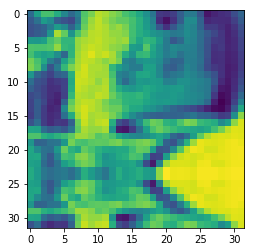

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train_task_transformed[1*72+5][...,0])

In [4]:
n, k = (10, 4)
from models.wide_residual_network import create_wide_residual_network
mdl1 = create_wide_residual_network((x_train.shape[1:]), transformer.n_transforms, n, k)
mdl2 = create_wide_residual_network((21,21,1), transformer.n_transforms, n, k)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
mdl1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
mdl2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 21, 21, 16)   144         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 21, 21, 16)   64          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 21, 21, 16)   0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
conv2d_12 

In [9]:
n_channels = x_train.shape[get_channels_axis()]
input_side = 21#x_train.shape[2]  # channel side will always be at shape[2]
enc = conv_encoder(input_side, n_channels)

In [10]:
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21, 21, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 64)        1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
activation_20 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
batch_normalization_19 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
activation_21 (Activation)   (None, 6, 6, 128)         0         
__________